<a href="https://colab.research.google.com/github/mcPython95/cotton-plant-disease-detection/blob/main/cotton_plant_disease_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Cotton Plant Disease Detection using RESNET152 pretrained model***

# Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import time
import copy
import os
import random
from PIL import Image
from math import ceil
import warnings
import jax
import torch.multiprocessing as mp

os.environ['OMP_NUM_THREADS'] = '1'
warnings.filterwarnings("ignore", message=".*will create.*worker processes.*")
warnings.filterwarnings("ignore", message="os.fork() was called.*")
mp.set_start_method('spawn', force=True)

# Load dataset


In [3]:
DataDir = '/content/drive/MyDrive/cotton plant disease detection/dataset/Cotton Disease/'

# Preprocessing

In [4]:
import os
from torchvision import datasets, transforms

def preprocess_images(data_dir):
    transform = transforms.Compose([
        transforms.RandomResizedCrop(256),
        transforms.RandomHorizontalFlip(),
        transforms.RandomAffine(90, scale=(1, 1.5)),
        transforms.ToTensor(),
        transforms.Normalize([.485, .456, .406], [.229, .224, .225])
    ])

    processed_images = {}
    for split in ['train', 'val', 'test']:
        processed_images[split] = datasets.ImageFolder(os.path.join(data_dir, split), transform)
    return processed_images


preprocessed_images = preprocess_images(DataDir)


# Data summary

In [13]:
from collections import Counter

# This loads data for the model
dataloaders = {x: torch.utils.data.DataLoader(preprocessed_images[x], batch_size = 4, shuffle = True, num_workers = 4,pin_memory=True)
               for x in ['train', 'val','test']}

# These are the number of images in both, training and validation sets:
dataset_sizes = {x: len(preprocessed_images[x]) for x in ['train', 'val','test']}

# These refer to the categories in the data:
class_names = preprocessed_images['train'].classes

# Get the number of images in each class for each dataset split
class_counts = {x: Counter(preprocessed_images[x].targets) for x in ['train', 'val', 'test']}

print("Dataset Summary:")
print("-" * 20)


for (phase,size),(classes,counts) in zip(dataset_sizes.items(),class_counts.items()):
    print(f"\n{phase.capitalize()} set: {size} images ")
    for class_name, count in counts.items():
        print(f"{phase}/{class_names[class_name]}: {count} images")


# Print class names
print("\nClass Names:")
print("-" * 20)
print(", ".join(class_names))

Dataset Summary:
--------------------

Train set: 1951 images 
train/diseased cotton leaf: 288 images
train/diseased cotton plant: 815 images
train/fresh cotton leaf: 427 images
train/fresh cotton plant: 421 images

Val set: 253 images 
val/diseased cotton leaf: 43 images
val/diseased cotton plant: 78 images
val/fresh cotton leaf: 66 images
val/fresh cotton plant: 66 images

Test set: 106 images 
test/diseased cotton leaf: 25 images
test/diseased cotton plant: 28 images
test/fresh cotton leaf: 26 images
test/fresh cotton plant: 27 images

Class Names:
--------------------
diseased cotton leaf, diseased cotton plant, fresh cotton leaf, fresh cotton plant


# Visualize dataset

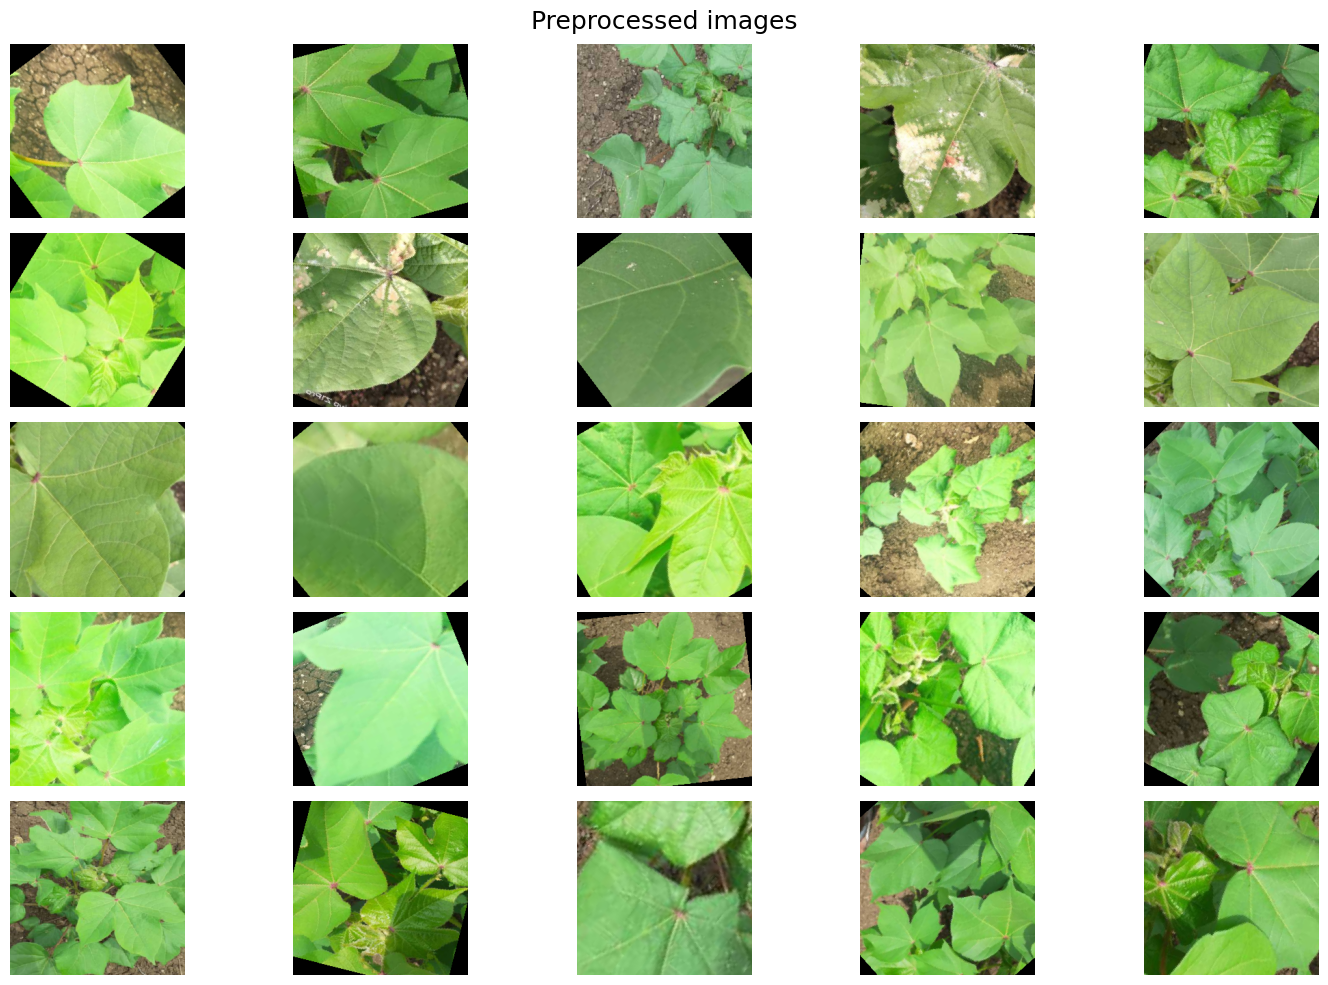

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

def sample_images(dataset, num_samples=25):
    indices = random.sample(range(len(dataset)), num_samples)
    images = [dataset[i][0] for i in indices]
    return torch.stack(images)


def show_images(no_of_images = 25,title = ''):
        plt.figure(figsize=(15,10))
        # Sample 25 images from the training dataset
        inputs = sample_images(preprocessed_images['train'])
        for i in range(no_of_images):
            ax = plt.subplot(int(no_of_images/5), 5, i + 1)
            imshow(inputs[i])
            ax.axis('off')
        plt.suptitle(title, fontsize=18)
        plt.tight_layout()  # Adjust layout for better spacing
        plt.show()


show_images(no_of_images = 25,title  = 'Preprocessed images')

# Setting device parameters

In [7]:
#If cuda runtime is availble set the device to cuda else cpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Build model

# ResNet152

In [22]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import matplotlib.pyplot as plt



def initialize_model(num_classes):
    """Initialize the ResNet152 model, criterion, optimizer, and scheduler."""
    model = models.resnet152(weights=models.ResNet152_Weights.DEFAULT)

    # Modify the final layer
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_features, 512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, num_classes)
    )

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001,momentum=0.9)
    scheduler = ReduceLROnPlateau(optimizer, mode = 'min', patience=3)
    return model, criterion, optimizer, scheduler

def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs=10):
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val':
                scheduler.step(epoch_loss)

    return model, history

def evaluate_model(model, dataloader):
    model.eval()
    running_corrects = 0
    dataset_size = 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
            dataset_size += labels.size(0)

    accuracy = running_corrects.double() / dataset_size
    print(f'\nTest Accuracy: {accuracy:.4f}')


# Train model

In [24]:
num_classes = 4
model, criterion, optimizer, scheduler = initialize_model(num_classes)
model, history = train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs = 20)

Epoch 1/20
----------


100%|██████████| 488/488 [01:29<00:00,  5.47it/s]


train Loss: 1.0173 Acc: 0.5618


100%|██████████| 64/64 [00:15<00:00,  4.26it/s]


val Loss: 0.5319 Acc: 0.8300
Epoch 2/20
----------


100%|██████████| 488/488 [01:27<00:00,  5.59it/s]


train Loss: 0.5098 Acc: 0.8098


100%|██████████| 64/64 [00:14<00:00,  4.27it/s]


val Loss: 0.2732 Acc: 0.9170
Epoch 3/20
----------


100%|██████████| 488/488 [01:27<00:00,  5.59it/s]


train Loss: 0.3874 Acc: 0.8596


100%|██████████| 64/64 [00:14<00:00,  4.30it/s]


val Loss: 0.1787 Acc: 0.9368
Epoch 4/20
----------


100%|██████████| 488/488 [01:29<00:00,  5.46it/s]


train Loss: 0.3318 Acc: 0.8806


100%|██████████| 64/64 [00:16<00:00,  3.89it/s]


val Loss: 0.1765 Acc: 0.9368
Epoch 5/20
----------


100%|██████████| 488/488 [01:28<00:00,  5.50it/s]


train Loss: 0.2738 Acc: 0.8975


100%|██████████| 64/64 [00:15<00:00,  4.26it/s]


val Loss: 0.1196 Acc: 0.9565
Epoch 6/20
----------


100%|██████████| 488/488 [01:26<00:00,  5.64it/s]


train Loss: 0.2314 Acc: 0.9200


100%|██████████| 64/64 [00:14<00:00,  4.28it/s]


val Loss: 0.0849 Acc: 0.9723
Epoch 7/20
----------


100%|██████████| 488/488 [01:27<00:00,  5.61it/s]


train Loss: 0.2420 Acc: 0.9062


100%|██████████| 64/64 [00:14<00:00,  4.30it/s]


val Loss: 0.1039 Acc: 0.9644
Epoch 8/20
----------


100%|██████████| 488/488 [01:26<00:00,  5.67it/s]


train Loss: 0.2098 Acc: 0.9257


100%|██████████| 64/64 [00:17<00:00,  3.74it/s]


val Loss: 0.1388 Acc: 0.9605
Epoch 9/20
----------


100%|██████████| 488/488 [01:26<00:00,  5.66it/s]


train Loss: 0.1920 Acc: 0.9339


100%|██████████| 64/64 [00:14<00:00,  4.27it/s]


val Loss: 0.0921 Acc: 0.9605
Epoch 10/20
----------


100%|██████████| 488/488 [01:27<00:00,  5.60it/s]


train Loss: 0.1684 Acc: 0.9380


100%|██████████| 64/64 [00:14<00:00,  4.32it/s]


val Loss: 0.1633 Acc: 0.9368
Epoch 11/20
----------


100%|██████████| 488/488 [01:25<00:00,  5.68it/s]


train Loss: 0.1648 Acc: 0.9477


100%|██████████| 64/64 [00:14<00:00,  4.43it/s]


val Loss: 0.0836 Acc: 0.9605
Epoch 12/20
----------


100%|██████████| 488/488 [01:27<00:00,  5.56it/s]


train Loss: 0.1448 Acc: 0.9452


100%|██████████| 64/64 [00:14<00:00,  4.34it/s]


val Loss: 0.1376 Acc: 0.9605
Epoch 13/20
----------


100%|██████████| 488/488 [01:25<00:00,  5.67it/s]


train Loss: 0.1528 Acc: 0.9477


100%|██████████| 64/64 [00:14<00:00,  4.41it/s]


val Loss: 0.1244 Acc: 0.9565
Epoch 14/20
----------


100%|██████████| 488/488 [01:26<00:00,  5.62it/s]


train Loss: 0.1431 Acc: 0.9513


100%|██████████| 64/64 [00:14<00:00,  4.41it/s]


val Loss: 0.0764 Acc: 0.9763
Epoch 15/20
----------


100%|██████████| 488/488 [01:25<00:00,  5.71it/s]


train Loss: 0.1436 Acc: 0.9482


100%|██████████| 64/64 [00:14<00:00,  4.39it/s]


val Loss: 0.0844 Acc: 0.9763
Epoch 16/20
----------


100%|██████████| 488/488 [01:26<00:00,  5.62it/s]


train Loss: 0.1348 Acc: 0.9534


100%|██████████| 64/64 [00:14<00:00,  4.35it/s]


val Loss: 0.1135 Acc: 0.9486
Epoch 17/20
----------


100%|██████████| 488/488 [01:25<00:00,  5.71it/s]


train Loss: 0.1549 Acc: 0.9508


100%|██████████| 64/64 [00:16<00:00,  3.91it/s]


val Loss: 0.1145 Acc: 0.9723
Epoch 18/20
----------


100%|██████████| 488/488 [01:26<00:00,  5.66it/s]


train Loss: 0.1483 Acc: 0.9477


100%|██████████| 64/64 [00:14<00:00,  4.37it/s]


val Loss: 0.1152 Acc: 0.9763
Epoch 19/20
----------


100%|██████████| 488/488 [01:27<00:00,  5.61it/s]


train Loss: 0.1442 Acc: 0.9462


100%|██████████| 64/64 [00:14<00:00,  4.39it/s]


val Loss: 0.0847 Acc: 0.9723
Epoch 20/20
----------


100%|██████████| 488/488 [01:25<00:00,  5.70it/s]


train Loss: 0.1633 Acc: 0.9441


100%|██████████| 64/64 [00:14<00:00,  4.37it/s]

val Loss: 0.0704 Acc: 0.9684


# Evaluate the model

In [25]:
evaluate_model(model, dataloaders['test'])

100%|██████████| 27/27 [00:31<00:00,  1.17s/it]


Test Accuracy: 0.9623


# Plot history

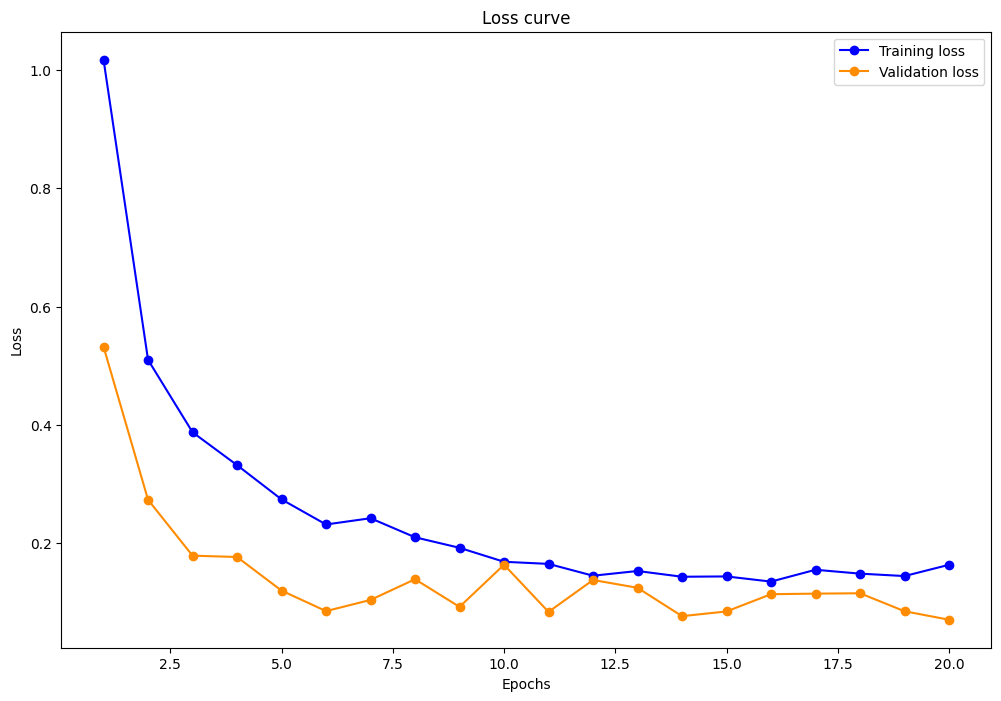

In [61]:
epochs = range(1, len(history['train_loss']) + 1)

plt.figure(figsize=(12, 8))
plt.plot(epochs, history['train_loss'], marker = 'o',color = 'blue', label='Training loss')
plt.plot(epochs, history['val_loss'], marker = 'o',color = 'darkorange', label='Validation loss')
plt.title('Loss curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

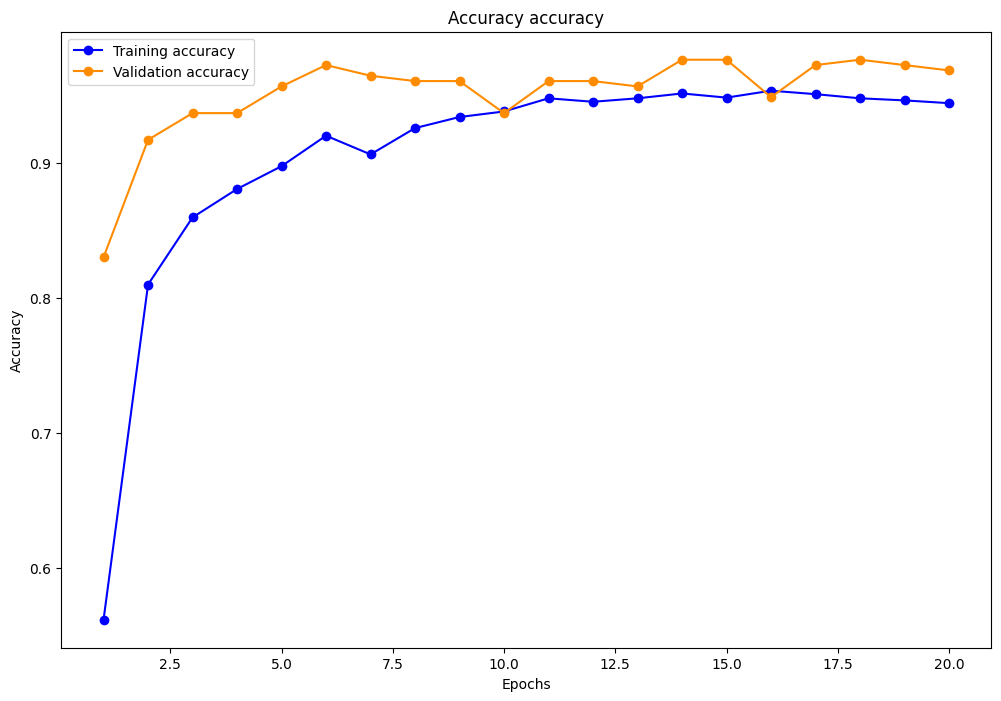

In [62]:
plt.figure(figsize=(12, 8))
plt.plot(epochs, history['train_acc'], marker = 'o',color = 'blue', label='Training accuracy')
plt.plot(epochs, history['val_acc'], marker = 'o',color = 'darkorange', label='Validation accuracy')
plt.title('Accuracy accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

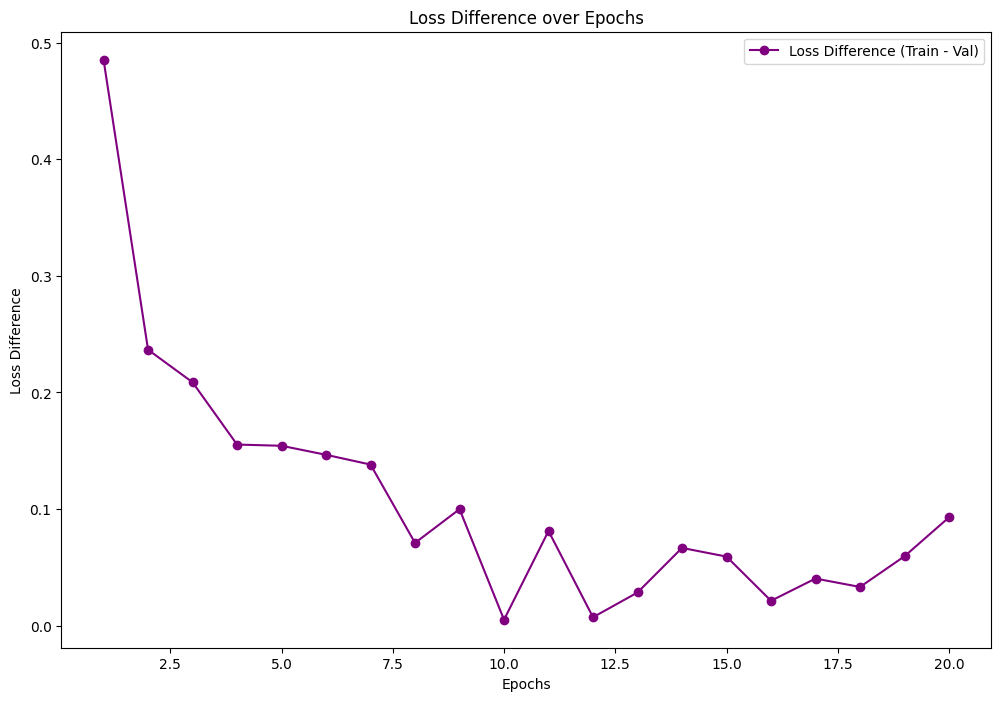

In [34]:
import matplotlib.pyplot as plt


# Calculate the difference between training and validation loss
loss_diff = [train - val for train, val in zip(history['train_loss'], history['val_loss'])]

# Plotting the loss difference
plt.figure(figsize=(12, 8))
plt.plot(epochs, loss_diff, marker='o', color='purple', label='Loss Difference (Train - Val)')
plt.title('Loss Difference over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss Difference')
plt.legend()
plt.show()


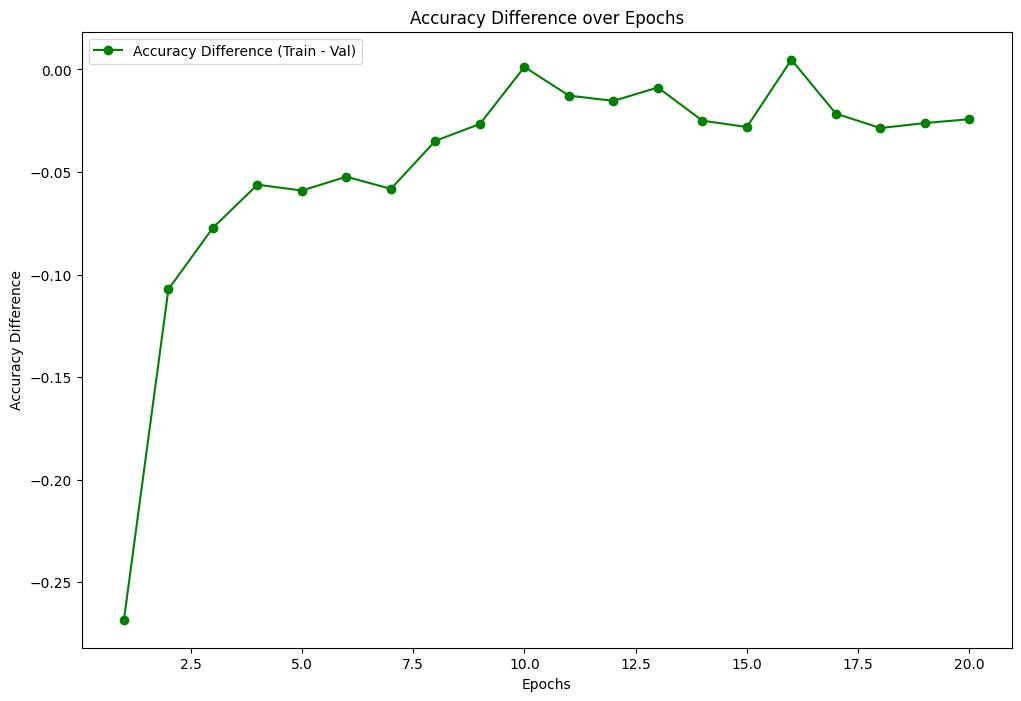

In [35]:
# Calculate the difference between training and validation accuracy
acc_diff = [train - val for train, val in zip(history['train_acc'], history['val_acc'])]

# Plotting the accuracy difference
plt.figure(figsize=(12, 8))
plt.plot(epochs, acc_diff, marker='o', color='green', label='Accuracy Difference (Train - Val)')
plt.title('Accuracy Difference over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy Difference')
plt.legend()
plt.show()


# Save Model

In [9]:
# #save the trained model in pytorch format
torch.save(model, '/content/drive/MyDrive/cotton plant disease detection/cotton_plant_dis_det_model.pt')

# Load Model

In [11]:
# Load the entire model from .pt file
loaded_model = torch.load('/content/drive/MyDrive/cotton plant disease detection/cotton_plant_dis_det_model.pt',map_location=torch.device('cpu'))

# Predictions

# Predict images



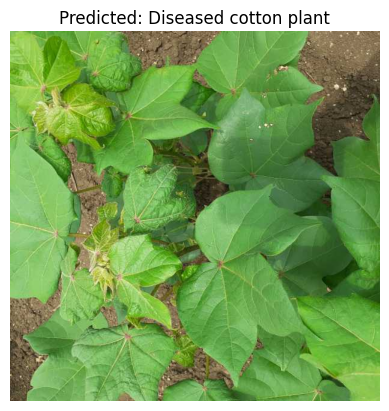

In [18]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
import torch

def predict_image(model, image_path, device, class_names):
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Load the image
    original_image = Image.open(image_path).convert('RGB')

    # Preprocess the image
    image = transform(original_image)
    image_tensor = image.unsqueeze(0)  # Add a batch dimension

    model.to(device)
    model.eval()

    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        _, preds = torch.max(outputs, 1)

    pred_class = class_names[preds.item()]

    return pred_class, original_image

def imshow(image, title=None):
    """Display PIL image."""
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.axis('off')  # Hide axes for better visualization
    plt.show()
    print()

image_path = '/content/drive/MyDrive/cotton plant disease detection/dataset/Cotton Disease/test/diseased cotton plant/dd (29)_iaip.jpg'
predicted_class, original_image = predict_image(loaded_model, image_path, device, class_names)
imshow(original_image, title=f'Predicted: {predicted_class.capitalize()}')

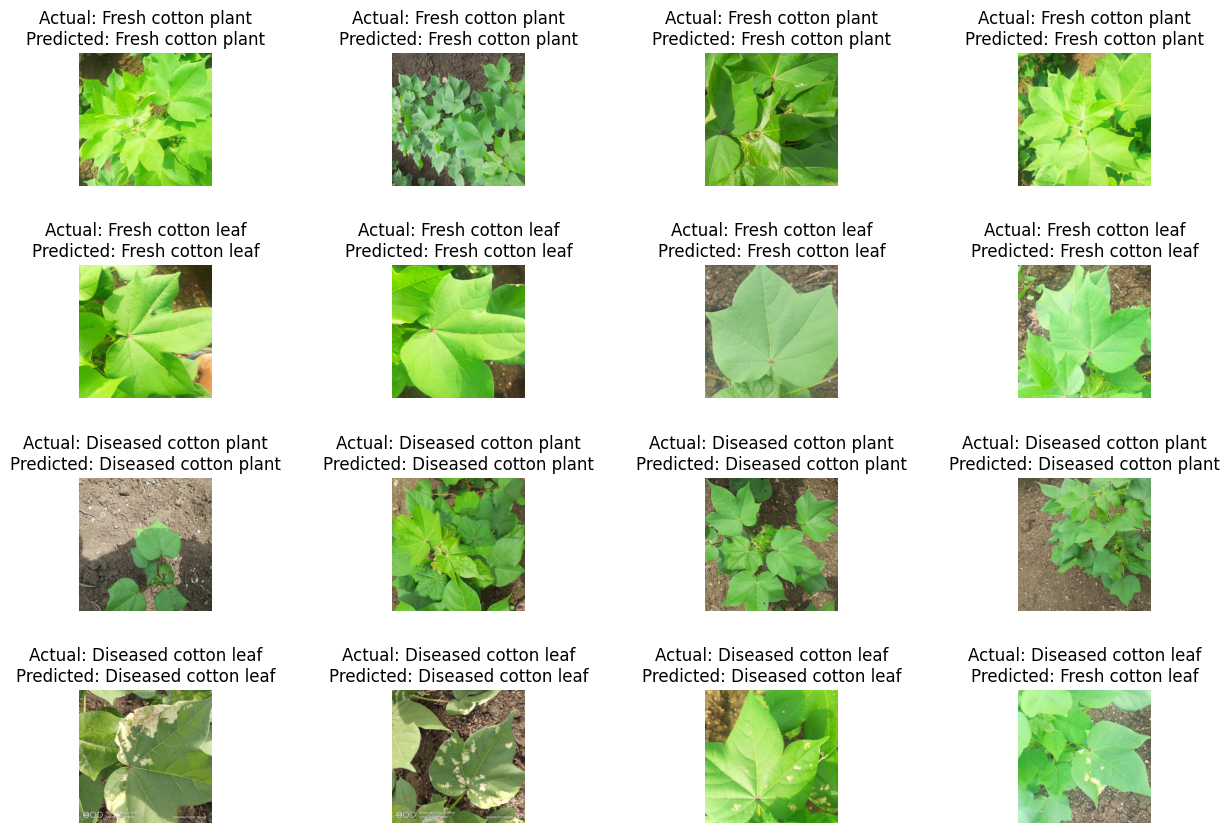

In [28]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import transforms

random.seed(63235)

# Define the function to list subdirectories and randomly select 4 images from each
def select_random_images(root_dir, num_images=4):
    selected_images = []
    for subdir, _, files in os.walk(root_dir):
        files = [os.path.join(subdir, f) for f in files if f.endswith(('jpg', 'jpeg', 'png'))]
        if files:
            actual_class = os.path.basename(subdir)
            selected_images.extend([(f, actual_class) for f in random.sample(files, min(num_images, len(files)))])
    return selected_images

# Define the function to predict image class
def predict_image(model, image_path, device, class_names):
    image = Image.open(image_path).convert('RGB')
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(image).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(input_tensor)
    _, predicted = torch.max(outputs, 1)
    predicted_class = class_names[predicted.item()]
    return predicted_class, image

# Function to display images with actual and predicted classes
def display_images_with_predictions(images, actual_classes, predictions):
    plt.figure(figsize=(15, 10))
    for i, (img, actual, pred) in enumerate(zip(images, actual_classes, predictions)):
        plt.subplot(4, 4, i+1)
        plt.imshow(img)
        plt.title(f'Actual: {actual.capitalize()}\nPredicted: {pred.capitalize()}')
        plt.axis('off')
    plt.subplots_adjust(wspace=0.4, hspace=0.6)
    plt.show()

# Define the main function
def main():
    root_dir = '/content/drive/MyDrive/cotton plant disease detection/dataset/Cotton Disease/test'
    selected_images = select_random_images(root_dir)

    predictions = []
    images = []
    actual_classes = []
    for image_path, actual_class in selected_images:
        predicted_class, original_image = predict_image(loaded_model, image_path, device, class_names)
        predictions.append(predicted_class)
        images.append(original_image)
        actual_classes.append(actual_class)

    display_images_with_predictions(images, actual_classes, predictions)

# Execute the main function
if __name__ == '__main__':
    main()


# Classification report

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)


def predict(model, dataloaders, device, class_names, num_images=60):
    model.to(device)
    was_training = model.training
    model.eval()
    images_so_far = 1
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            if i < num_images:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)

                all_preds.extend(preds.view(-1).cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
            else:
                break

    model.train(mode=was_training)

    return all_labels,all_preds

y_true, y_pred = predict(loaded_model, dataloaders, device, class_names,num_images = 600)


# Calculate classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


Classification Report:
                       precision    recall  f1-score   support

 diseased cotton leaf       1.00      0.95      0.98        43
diseased cotton plant       0.99      0.96      0.97        78
    fresh cotton leaf       0.96      0.97      0.96        66
   fresh cotton plant       0.94      0.98      0.96        66

             accuracy                           0.97       253
            macro avg       0.97      0.97      0.97       253
         weighted avg       0.97      0.97      0.97       253



# Confusion matrix

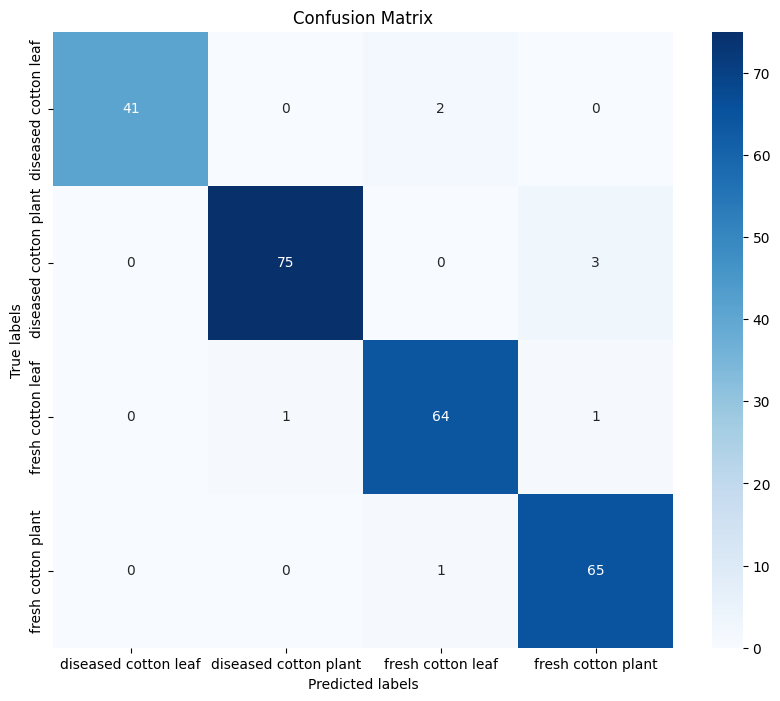

In [25]:
from sklearn.metrics import  confusion_matrix

# Generate confusion matrix
cm= confusion_matrix(y_true, y_pred)
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Precision - Recall curve

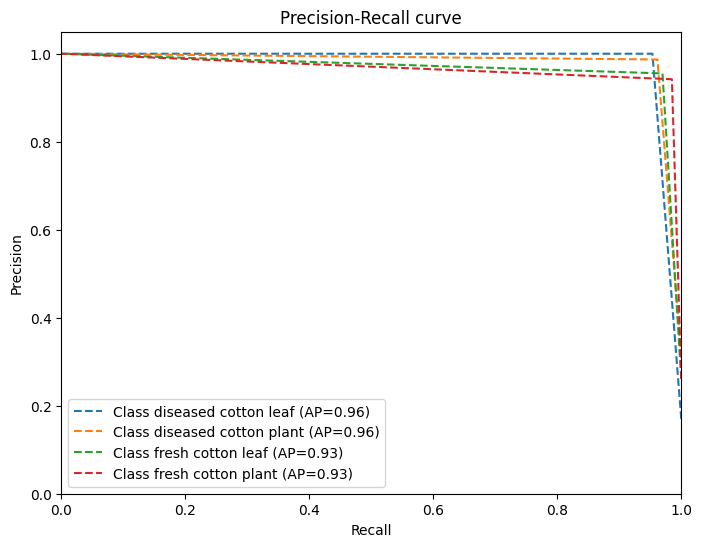

In [22]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# Convert y_true and y_pred to one-hot encoding
y_true_one_hot = np.eye(len(class_names))[y_true]
y_pred_one_hot = np.eye(len(class_names))[y_pred]

# Calculate precision and recall for each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(len(class_names)):
    precision[i], recall[i], _ = precision_recall_curve(y_true_one_hot[:, i], y_pred_one_hot[:, i])
    average_precision[i] = average_precision_score(y_true_one_hot[:, i], y_pred_one_hot[:, i])

# Plot precision-recall curves for each class
plt.figure(figsize=(8, 6))
for i in range(len(class_names)):
    plt.plot(recall[i], precision[i], label=f'Class {class_names[i]} (AP={average_precision[i]:0.2f})',linestyle ='--' )

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve')
plt.legend(loc='best')
plt.show()


# Roc curve

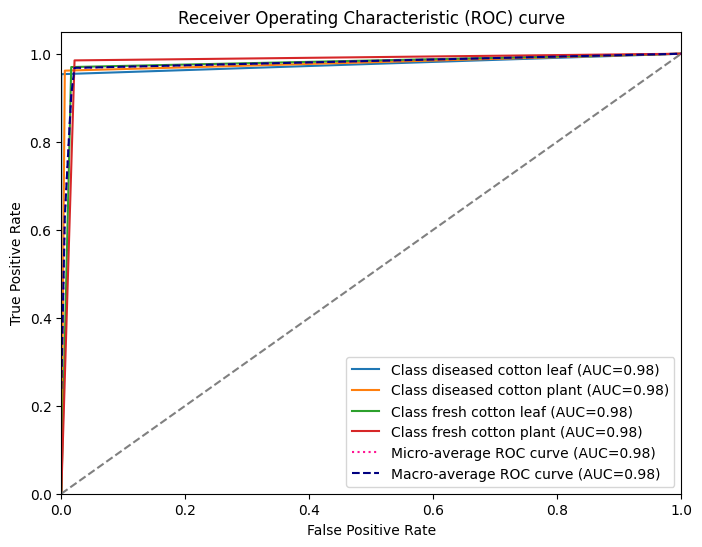

In [23]:
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_one_hot[:, i], y_pred_one_hot[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Aggregate true positive rates and false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(class_names))]))

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(class_names)):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Average and compute AUC for micro-average ROC curve
mean_tpr /= len(class_names)
micro_auc = auc(all_fpr, mean_tpr)

# Plot individual class ROC curves
plt.figure(figsize=(8, 6))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f'Class {class_names[i]} (AUC={roc_auc[i]:0.2f})')

# Plot micro-average ROC curve
plt.plot(all_fpr, mean_tpr, label=f'Micro-average ROC curve (AUC={micro_auc:0.2f})', color='deeppink', linestyle=':')

# Compute macro-average ROC curve and AUC
macro_auc = np.mean(list(roc_auc.values()))
macro_fpr = all_fpr
macro_tpr = mean_tpr
plt.plot(macro_fpr, macro_tpr, label=f'Macro-average ROC curve (AUC={macro_auc:0.2f})', color='navy', linestyle='--')

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) curve')
plt.legend(loc='best')
plt.show()


# Performance metrics

In [26]:
import numpy as np
from sklearn.metrics import confusion_matrix


# Total number of samples
total_samples = np.sum(cm)

accuracy = np.trace(cm) / total_samples
precision = np.mean(np.diag(cm) / np.sum(cm, axis=0))
recall = np.mean(np.diag(cm) / np.sum(cm, axis=1))
f1_score = 2 * (precision * recall) / (precision + recall)
specificity = np.mean([cm[i, i] / (np.sum(cm[:, i]) - cm[i, i] + cm[i, i]) for i in range(cm.shape[0])])
error_rate = 1 - accuracy


print("-" * 40)
print("\tPerformance metrics")
print("-" * 40)

# Print overall metrics
print(f'Accuracy\t\t: {accuracy:.4f}')
print(f'Precision\t\t: {precision:.4f}')
print(f'Recall \t\t\t: {recall:.4f}')
print(f'F1-score\t\t: {f1_score:.4f}')
print(f'Specificity \t\t: {specificity:.4f}')
print(f'ROC-AUC\t\t\t: {macro_auc:.4f}')
print(f'Error Rate \t\t: {error_rate:.4f}')


----------------------------------------
	Performance metrics
----------------------------------------
Accuracy		: 0.9684
Precision		: 0.9710
Recall 			: 0.9674
F1-score		: 0.9692
Specificity 		: 0.9710
ROC-AUC			: 0.9783
Error Rate 		: 0.0316
